In [1]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [35]:
import os
import datetime as dt
import numpy as np
import pandas as pd
import pandas_profiling as pdp

In [36]:
#전체기후날씨데이터(weather.csv) 불러오기--------------------------
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

original = pd.read_csv('data.csv')

C:\Users\creal\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (6,7,8,10,12,13,14,15,18,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
original = original.iloc[:,1:]

In [ ]:
#스테이션 배정됨 - 16~20번 할당
bright_bf = original[(original["station_nbr"]<21)&(original["station_nbr"]>15)]
bright_bf

In [64]:
# 스테이션번호로 할당된 스토어 넘버 확인
set(bright_bf["store_nbr"])

{9, 14, 17, 18, 23, 26, 30, 31, 34, 36, 45}

In [100]:
# 스토어 번호로 할당된 스토어당 아이템 넘버 확인 및 갯수확인
ls = list(set(bright_bf["store_nbr"]))
ls.sort()
store_item = df.pivot_table("units","store_nbr","item_nbr", aggfunc=np.count_nonzero)
# avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)

for i in ls:
    print('store_nbr :' ,i)
    print(store_item.loc[i].dropna())

store_nbr : 9
item_nbr
5      944.0
10     337.0
42     487.0
45     946.0
93     160.0
105     50.0
Name: 9, dtype: float64
store_nbr : 14
item_nbr
9     819.0
15     77.0
25    917.0
33    229.0
50    127.0
70    196.0
88     47.0
93    123.0
Name: 14, dtype: float64
store_nbr : 17
item_nbr
9     938.0
37    938.0
48    483.0
71    268.0
Name: 17, dtype: float64
store_nbr : 18
item_nbr
5     939.0
37    945.0
57    238.0
72    364.0
Name: 18, dtype: float64
store_nbr : 23
item_nbr
5     937.0
29    475.0
45    946.0
56    366.0
Name: 23, dtype: float64
store_nbr : 26
item_nbr
2     371.0
5     946.0
45    946.0
Name: 26, dtype: float64
store_nbr : 30
item_nbr
13    233.0
16    868.0
44    868.0
49     52.0
51     76.0
65    350.0
Name: 30, dtype: float64
store_nbr : 31
item_nbr
9      946.0
45     946.0
67     594.0
93     157.0
98     366.0
104     38.0
Name: 31, dtype: float64
store_nbr : 34
item_nbr
9     945.0
31    323.0
45    946.0
52    576.0
84     38.0
93    109.0
Name: 34, 

In [40]:
def type_change_numeric(df, ls = []): 
    #ls에 있는 column name은 numeric형으로 바꾸지 않는다.
    cols = df.columns
    for i in cols:
        if i in ls:
            continue 
        df = df.replace(["M",None],np.NaN)
        df = df.replace(["T","  T"],0.005)
        df[i] = pd.to_numeric(df[i], errors='coerce')
        
    return df

In [41]:
#weather_p에 사전정제자료 삽입(codesum은 추가정제필요)
df = type_change_numeric(bright_bf,["station_nbr","codesum","date"])
df["date"] = pd.to_datetime(df["date"])
df["tdelta"] = df["tmax"]-df["tmin"]

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['DOW']= df['date'].dt.dayofweek
df['SS']= (df['month']//3)%4 


In [46]:
df.iloc[:,22:-6] = df.iloc[:,22:-6].astype(int)

In [49]:
df['mon'] = (df['DOW']==0).astype(int)
df['tue'] = (df['DOW']==1).astype(int)
df['wed'] = (df['DOW']==2).astype(int)
df['thr'] = (df['DOW']==3).astype(int)
df['fri'] = (df['DOW']==4).astype(int)
df['sat'] = (df['DOW']==5).astype(int)
df['sun'] = (df['DOW']==6).astype(int)

df.dtypes

### 

# 1. 스토어별 비교 플롯뿌리기

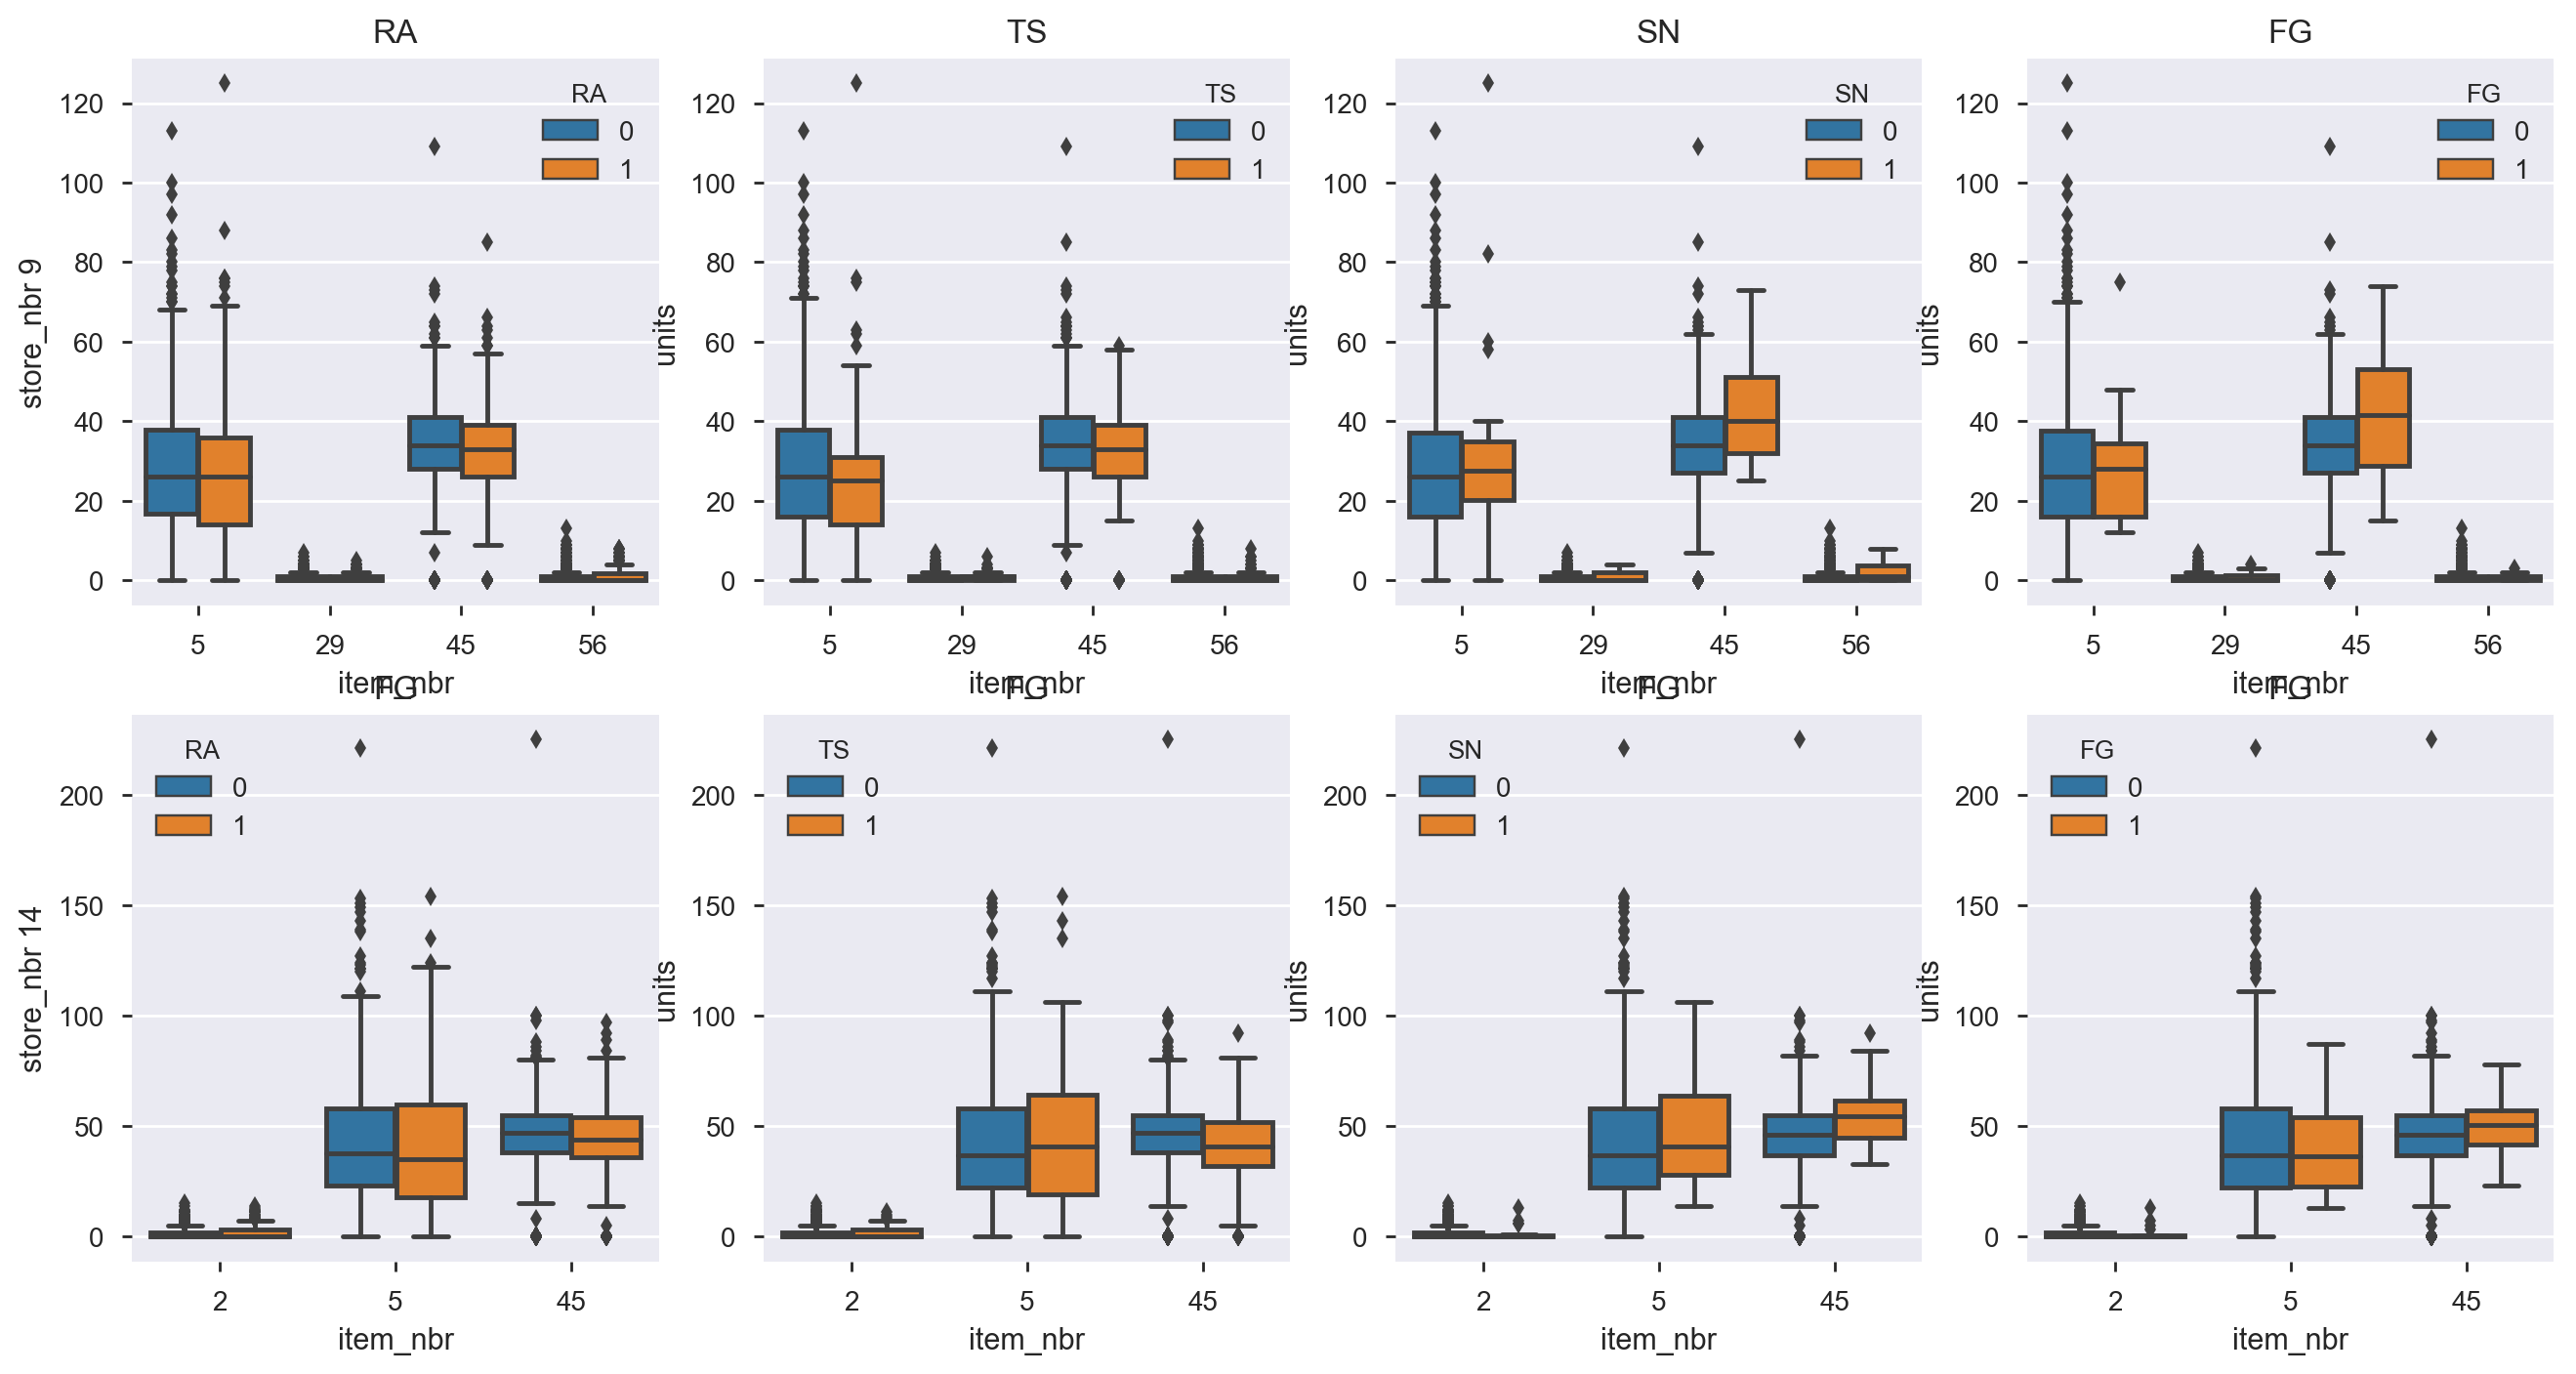

In [125]:
# 배정된 스토어 = {9, 14, 17, 18, 23, 26, 30, 31, 34, 36, 45}

fig = plt.figure(figsize={16,8})
ax11 = fig.add_subplot(241)
ax12 = fig.add_subplot(242)
ax13 = fig.add_subplot(243)
ax14 = fig.add_subplot(244)

temp = df[(df["store_nbr"]==23)&(df["units"]<500)]
sns.boxplot(ax=ax11, x="item_nbr", y="units", hue="RA", data=temp).set_title('RA')
sns.boxplot(ax=ax12, x="item_nbr", y="units", hue="TS", data=temp).set_title('TS')
sns.boxplot(ax=ax13, x="item_nbr", y="units", hue="SN", data=temp).set_title('SN')
sns.boxplot(ax=ax14, x="item_nbr", y="units", hue="FG", data=temp).set_title('FG')

ax11.set_ylabel('store_nbr 9')



ax21 = fig.add_subplot(245)
ax22 = fig.add_subplot(246)
ax23 = fig.add_subplot(247)
ax24 = fig.add_subplot(248)

temp = df[(df["store_nbr"]==26)&(df["units"]<250)]
sns.boxplot(ax=ax21, x="item_nbr", y="units", hue="RA", data=temp)
sns.boxplot(ax=ax22, x="item_nbr", y="units", hue="TS", data=temp)
sns.boxplot(ax=ax23, x="item_nbr", y="units", hue="SN", data=temp)
sns.boxplot(ax=ax24, x="item_nbr", y="units", hue="FG", data=temp)

ax21.set_ylabel('store_nbr 14')

# ["RA","BR","HZ","TS","FG","SN"]
plt.show()

# 2. 아이템별 비교 플롯뿌리기

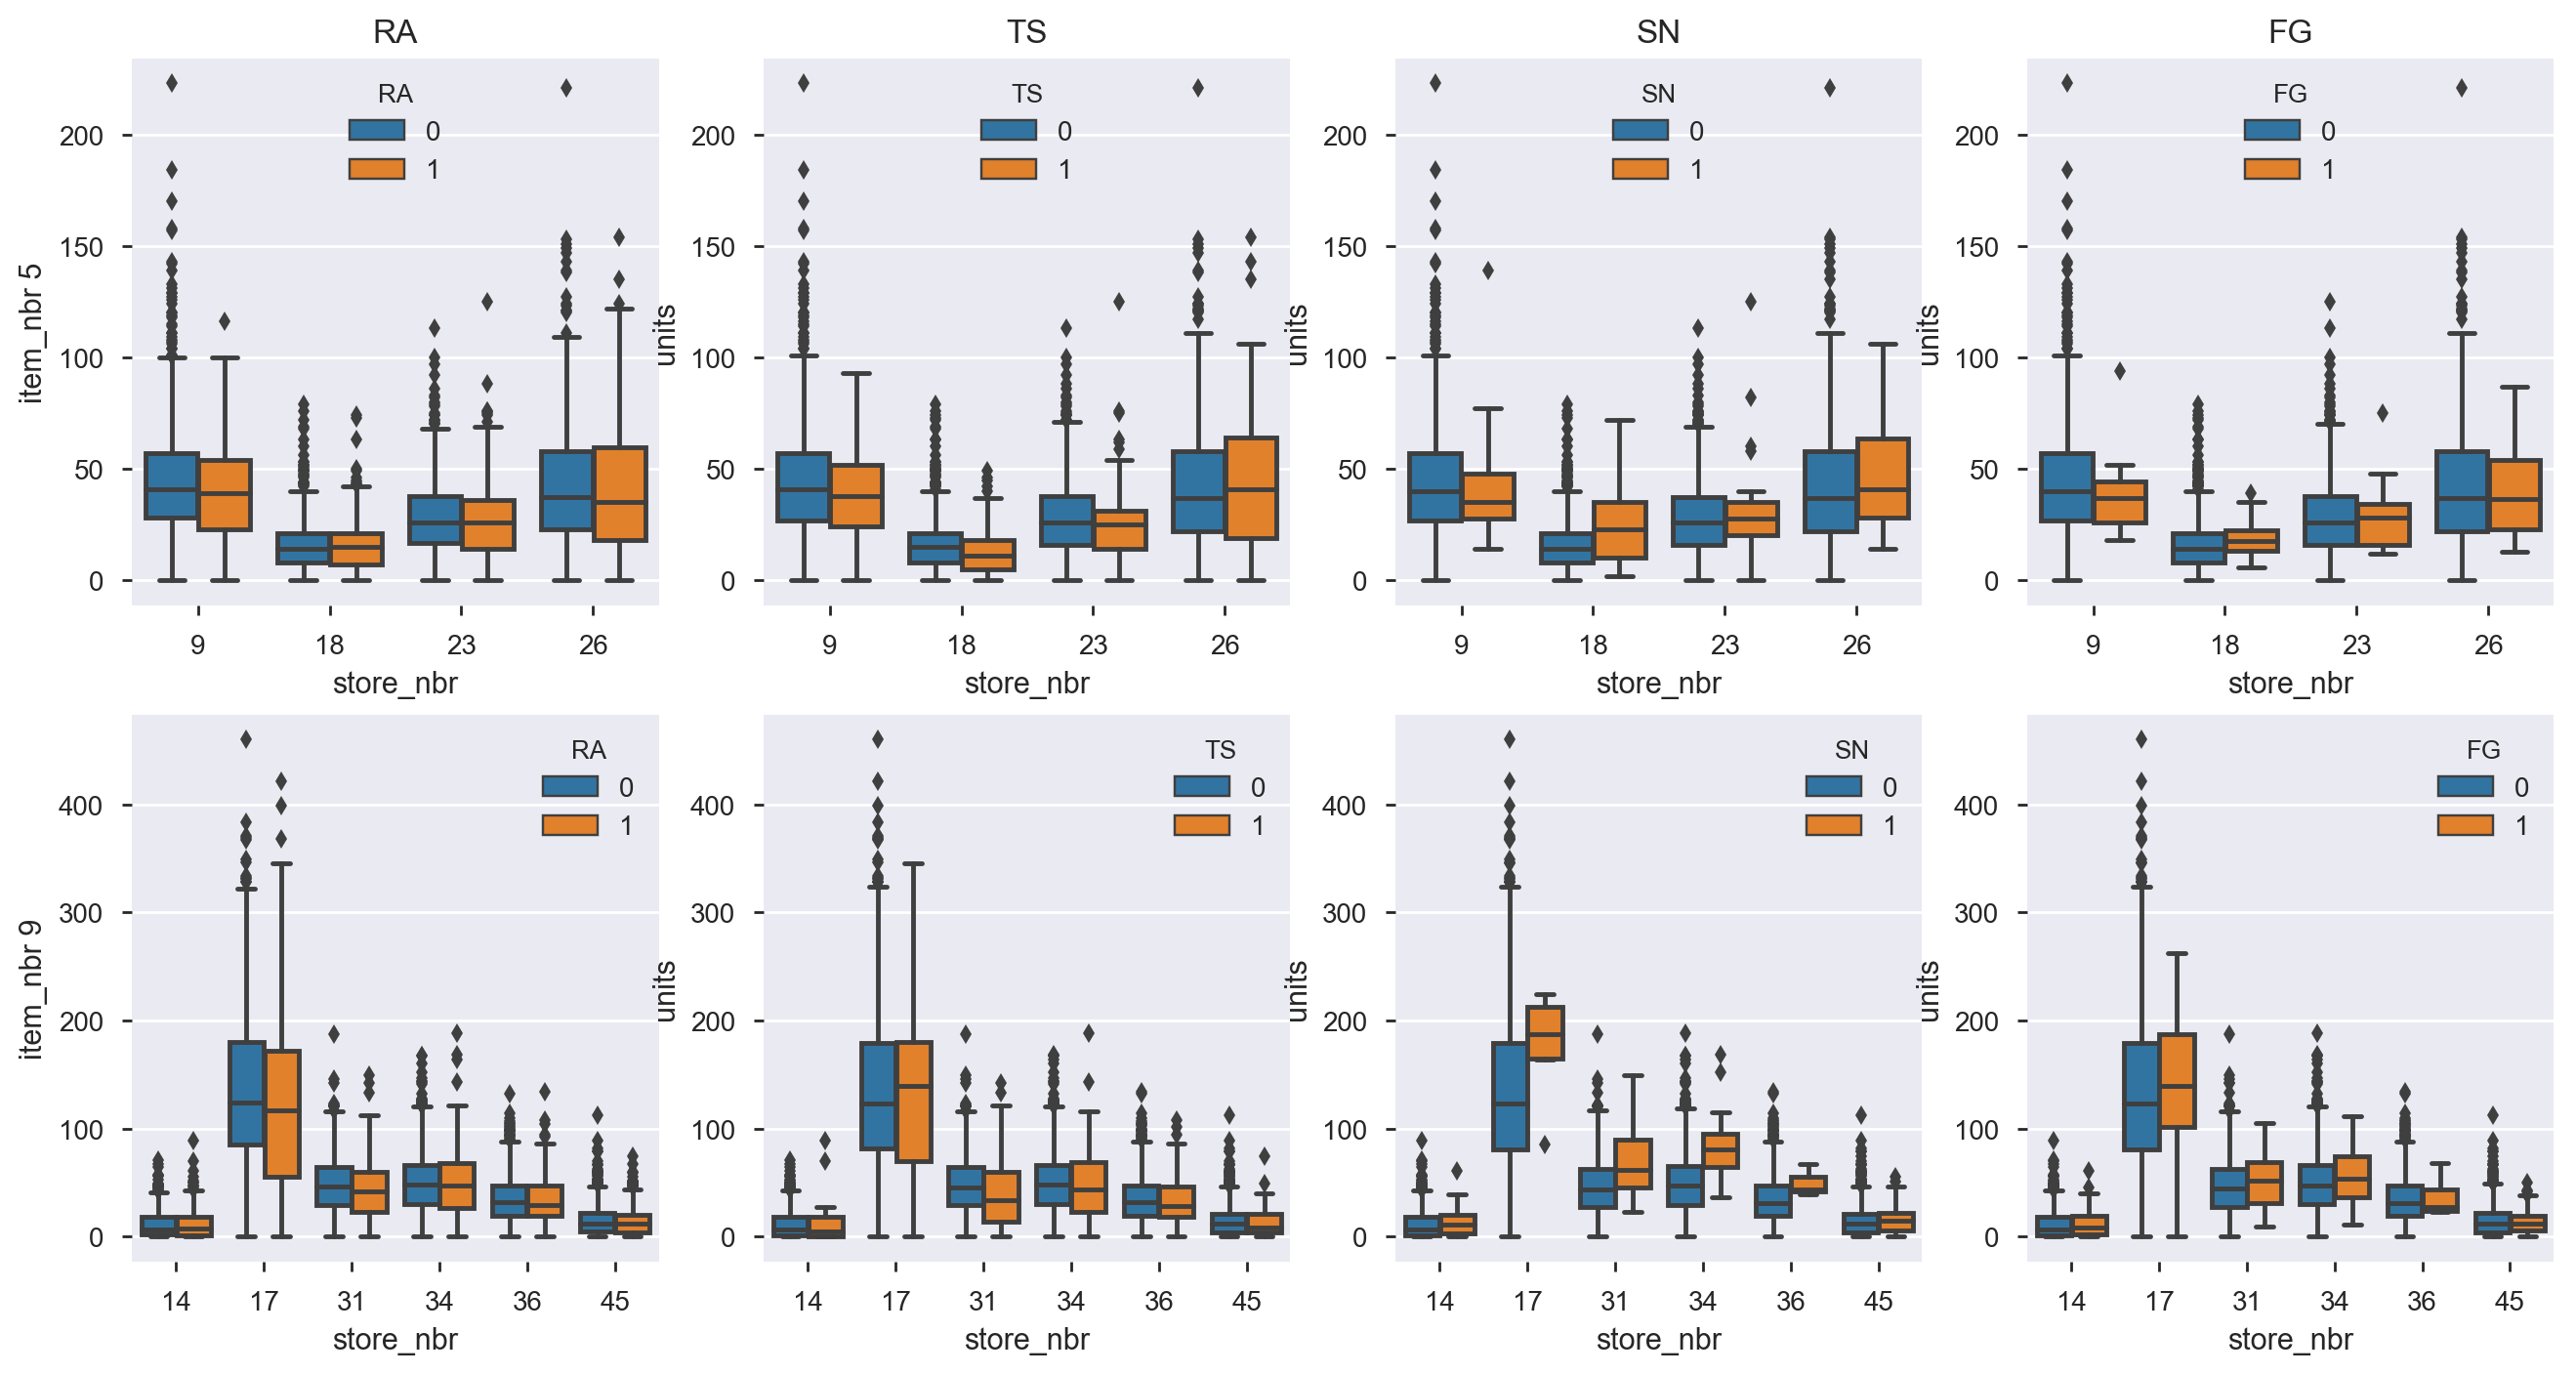

In [127]:
# 10개이상의 스토어에서 판매되는 아이템들 = {5,9,45,93}
# 5개 이상의 스토어에서 판매되는 아이템들 = {15,16,37,44,50,68,86,105}
fig = plt.figure(figsize={16,8})
ax11 = fig.add_subplot(241)
ax12 = fig.add_subplot(242)
ax13 = fig.add_subplot(243)
ax14 = fig.add_subplot(244)

temp = df[(df["item_nbr"]==5)&(df["units"]<500)]
sns.boxplot(ax=ax11, x="store_nbr", y="units", hue="RA", data=temp).set_title('RA')
sns.boxplot(ax=ax12, x="store_nbr", y="units", hue="TS", data=temp).set_title('TS')
sns.boxplot(ax=ax13, x="store_nbr", y="units", hue="SN", data=temp).set_title('SN')
sns.boxplot(ax=ax14, x="store_nbr", y="units", hue="FG", data=temp).set_title('FG')

ax11.set_ylabel('item_nbr 5')



ax21 = fig.add_subplot(245)
ax22 = fig.add_subplot(246)
ax23 = fig.add_subplot(247)
ax24 = fig.add_subplot(248)

temp = df[(df["item_nbr"]==9)&(df["units"]<500)]
sns.boxplot(ax=ax21, x="store_nbr", y="units", hue="RA", data=temp)
sns.boxplot(ax=ax22, x="store_nbr", y="units", hue="TS", data=temp)
sns.boxplot(ax=ax23, x="store_nbr", y="units", hue="SN", data=temp)
sns.boxplot(ax=ax24, x="store_nbr", y="units", hue="FG", data=temp)

ax21.set_ylabel('item_nbr 9')

# ["RA","BR","HZ","TS","FG","SN"]
plt.show()

In [56]:
df.corr().round(3)

,store_nbr,item_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,day,DOW,SS,mon,tue,wed,thr,fri,sat,sun
store_nbr,1.000,-0.156,-0.033,-0.046,-0.061,-0.030,-0.047,0.042,-0.035,-0.041,...,-0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
item_nbr,-0.156,1.000,-0.206,-0.032,0.021,-0.003,0.009,-0.019,0.009,0.009,...,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000
units,-0.033,-0.206,1.000,0.345,0.054,0.051,0.055,0.058,0.025,0.038,...,-0.058,0.037,-0.037,0.007,-0.014,-0.023,-0.028,-0.012,0.023,0.047
station_nbr,-0.046,-0.032,0.345,1.000,0.102,0.134,0.121,-0.042,0.083,0.098,...,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000
tmax,-0.061,0.021,0.054,0.102,1.000,0.911,0.979,0.424,0.887,0.946,...,0.030,-0.007,0.507,0.005,0.007,-0.000,0.002,-0.012,-0.002,0.001
tmin,-0.030,-0.003,0.051,0.134,0.911,1.000,0.976,0.383,0.954,0.976,...,0.024,-0.005,0.525,0.009,-0.003,-0.003,-0.001,-0.002,0.005,-0.006
tavg,-0.047,0.009,0.055,0.121,0.979,0.976,1.000,0.410,0.941,0.983,...,0.026,-0.007,0.528,0.007,0.002,-0.001,0.001,-0.008,0.002,-0.003
depart,0.042,-0.019,0.058,-0.042,0.424,0.383,0.410,1.000,0.415,0.421,...,0.022,-0.032,-0.043,0.017,0.017,0.001,0.014,-0.012,-0.024,-0.013
dewpoint,-0.035,0.009,0.025,0.083,0.887,0.954,0.941,0.415,1.000,0.984,...,0.016,0.005,0.534,-0.001,-0.007,-0.001,0.003,-0.001,0.007,-0.001
wetbulb,-0.041,0.009,0.038,0.098,0.946,0.976,0.983,0.421,0.984,1.000,...,0.024,-0.001,0.536,0.001,-0.001,0.001,-0.000,-0.003,0.003,-0.001


In [51]:
import pandas_profiling as pdp
pdp.ProfileReport(df)

Number of variables,58
Number of observations,58938
Total Missing (%),5.4%
Total size in memory,19.6 MiB
Average record size in memory,348.0 B
Numeric,21
Categorical,0
Boolean,28
Date,1
Text (Unique),0
Rejected,8
